In [48]:

import numpy as np
import pickle
import matplotlib.pyplot as plt
from minisom import MiniSom  
from sklearn.cluster import KMeans

In [49]:
print("SOM Assignment")

SOM Assignment


In [50]:
chainlink = np.genfromtxt('chainlink.vec', skip_header=4, usecols=list(range(3)))

In [51]:
chainlink
print(chainlink.shape)
d1=20
d2=25


(1000, 3)


In [111]:
chainlink_som_small = MiniSom(20, 25, 3, sigma=2, learning_rate=0.1,neighborhood_function='triangle',random_seed=10)
chainlink_som_small.train_random(chainlink, 1000)
chainlink_som_big = MiniSom(100, 60, 3, sigma=0.3, learning_rate=0.5)
chainlink_som_big.train_random(chainlink, 1000)

In [112]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec



In [113]:
# HIERARCHICAL CLUSTERING

In [114]:
from scipy import cluster


0.0025632698533985788
0.352
0.0038795286688477855
0.993


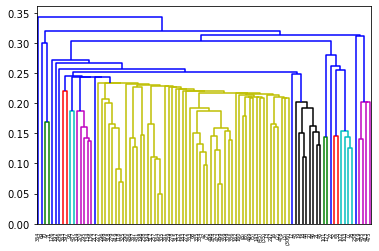

[[2.02000000e+02 4.90000000e+02 1.06265808e-02 2.00000000e+00]
 [3.51000000e+02 4.20000000e+02 1.17544820e-02 2.00000000e+00]
 [2.21000000e+02 3.94000000e+02 1.39009182e-02 2.00000000e+00]
 ...
 [9.94000000e+02 9.95000000e+02 3.12378540e-01 4.96000000e+02]
 [9.93000000e+02 9.96000000e+02 3.19491482e-01 4.99000000e+02]
 [3.64000000e+02 9.97000000e+02 3.43306285e-01 5.00000000e+02]]


In [122]:
chainlink_som_small.train_random(chainlink, 1000)

print(chainlink_som_small.quantization_error(chainlink))
print(chainlink_som_small.topographic_error(chainlink))

print(chainlink_som_big.quantization_error(chainlink))
print(chainlink_som_big.topographic_error(chainlink))



weights=chainlink_som_small.get_weights()
weights = chainlink_som_small.get_weights().reshape(d1*d2,-1) 





def hierarchy(weights):
    Z = cluster.hierarchy.linkage(weights,'single')
    d=cluster.hierarchy.dendrogram(Z,truncate_mode='level')
    #Y=cluster.hierarchy.single(weights)
    plt.show()
    print(Z)

    cutree = cluster.hierarchy.cut_tree(Z, n_clusters=[2,10])
    labels=cutree[:,1]
    #print("Labeling",labels)

    #print(cutree)
    return labels

labels=hierarchy(weights)


In [116]:
def winners_labels(som,weights,labels):
    winners_labels = np.zeros(shape=(d1,d2))
    for cnt, xx in enumerate (weights):
        w = som.winner(xx)
        l = labels[cnt]
        winners_labels[w[0],w[1]] = l
    return winners_labels

def dif_matrix(label_matrix):
    dif_mat = np.zeros(shape=label_matrix.shape)
    for i,row in enumerate(label_matrix):
        for j,label in enumerate(row):
            if i < label_matrix.shape[0]-1 and label_matrix[i][j] != label_matrix[i+1][j]:
                dif_mat[i][j] = 1
            elif j < label_matrix.shape[1]-1 and label_matrix[i][j] != label_matrix[i][j+1]:
                dif_mat[i][j] = 1
    return dif_mat

dif_matrix(winners_labels(chainlink_som_small,weights,labels))

print(np.unique(dif_matrix(winners_labels(chainlink_som_small,weights,labels))))

[0. 1.]


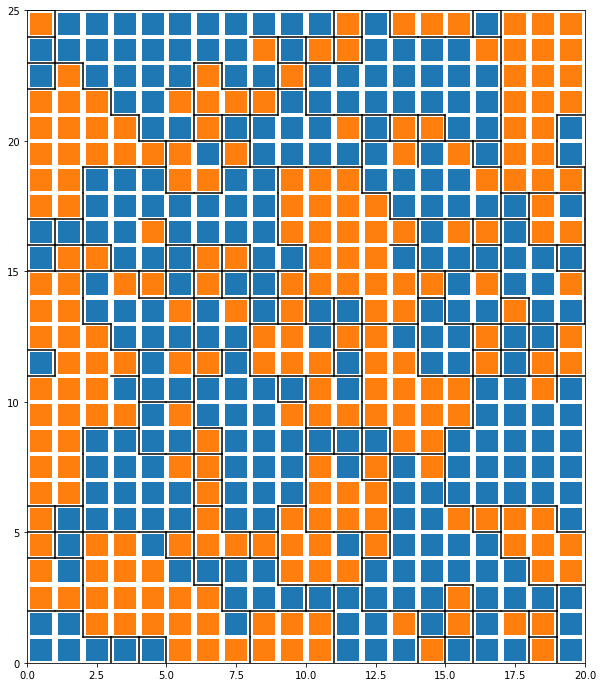

In [117]:
## import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

def plot_with_labelling(som, d1, d2, labels, coloring_labels, rweights, debug=False):

    plt.figure(figsize=(d1//2, d2//2))
    # Plotting the response for each pattern in the iris dataset
    #win_map = som.win_map(rweights)
    #plt.pcolor(som.distance_map().T, cmap='bone_r')  # plotting the distance map as background
    #plt.colorbar()
    # use different colors and markers for each label
    #markers = ['o', 's', 'D']
    colors = ['C' + str(i) for i in np.unique(coloring_labels)] #['C0', 'C1', 'C2', 'C3', 'C4']
    win_labels = winners_labels(som,rweights,labels)
    diff_mat_ = dif_matrix(win_labels)
    diff_mat = np.append(diff_mat_,np.ones((diff_mat_.shape[0],1)),axis=1)
    diff_mat = np.append(diff_mat,np.ones((1,diff_mat.shape[1])),axis=0)

    for cnt, xx in enumerate(rweights):
        w = som.winner(xx)  # getting the winner
        #w = xx
        # palce a marker on the winning position for the sample xx
        plt.plot(w[0]+.5, w[1]+.5, 's', markerfacecolor=colors[coloring_labels[cnt]],
                markeredgecolor=colors[coloring_labels[cnt]], markersize=20, markeredgewidth=2)
    def plot_borders(debug=False):
        border_color = lambda c : c if debug else 'black'
        for i,row in enumerate(diff_mat):
            for j,v in enumerate(row):
                if i < diff_mat.shape[0]-1 and j < diff_mat.shape[1]-1:
                    if v != 0: 
                        # case where
                        # - -  -
                        # -[1] 1
                        # - -  -
                        # then draw horizontal line
                        if i > 0 and diff_mat[i-1][j] != 0:
                            plt.plot([i,i+1],[j+1,j+1], color=border_color('red'))
                        # edge case where
                        # - - -
                        # [1] -
                        # - - -
                        # then draw horizontal line
                        elif i == 0 and j != 0:
                            plt.plot([i,i+1],[j+1,j+1], color=border_color('green'))    
                        # case where
                        # - 0  1
                        # -[1] 0
                        # - -  -
                        # then draw horizontal line
                        elif i > 0 and diff_mat[i-1][j] == 0 and diff_mat[i][j+1] == 0 and diff_mat[i-1][j+1] != 0:
                            plt.plot([i,i+1],[j+1,j+1], color=border_color('blue'))
                        # case where
                        # - 1  -
                        # -[1] -
                        # - -  -
                        # then draw vertical line
                        if diff_mat[i][j+1] != 0:
                            plt.plot([i+1,i+1],[j+1,j+2], color=border_color('black'))
                        # edge case where
                        # - [1] -
                        # -  -  -
                        # then draw vertical line
                        if j == 0 and i != 0:
                            plt.plot([i+1,i+1],[j,j+1], color=border_color('brown'))    
                    # case where
                    # - -  -
                    # -[0] 1
                    # - 1  0
                    # then draw vertical line
                    elif diff_mat[i+1][j] != 0 and diff_mat[i][j+1] != 0 and diff_mat[i+1][j+1] == 0:
                        plt.plot([i+1,i+1],[j+1,j+2], color=border_color('purple'))
    plot_borders(debug)
    plt.axis([0, d1, 0, d2])
    plt.show()

d1 = 20
d2 = 25
rweights = chainlink_som_small.get_weights().reshape(d1*d2,-1) # first argument is product of first two dimensions of the input dataset
Z = cluster.hierarchy.linkage(rweights,'ward')
labels = cluster.hierarchy.cut_tree(Z, n_clusters=2)
labels = [l[0] for l in labels]
plot_with_labelling(chainlink_som_small,d1,d2,labels,labels,rweights,debug=False)

In [118]:
# K-Means clustering

In [119]:


starting_weights = chainlink_som_small.get_weights()
print(starting_weights)
weightskM = chainlink_som_small.get_weights().reshape(d1*d2,-1) # first argument is product of first two dimensions of the input dataset

#x=weights[1]
#print(weights[x])
labels_kM = KMeans(n_clusters=2,random_state=0)
y_kmeans2 = kmeans2.fit(weightskM)
print("Y_Kmeans2",y_kmeans2)
#KMlabels=y_kmeans2.labels_

#print(KMlabels)


[[[ 4.78768093e-01 -8.45673489e-01  2.35833550e-01]
  [ 6.43051487e-01  9.82240976e-03 -7.50818762e-01]
  [-4.94012906e-01  4.74792306e-01 -6.83741381e-01]
  ...
  [-6.94094509e-01 -1.07739978e-01 -2.95533046e-01]
  [ 5.07100172e-01 -8.51939204e-01 -1.30571850e-01]
  [-6.69172264e-01  4.93513500e-01 -5.55565394e-01]]

 [[-2.30571253e-01 -4.63625262e-01  8.64562026e-02]
  [ 5.88190093e-01 -1.21682560e-01  1.63746783e-02]
  [ 4.91523713e-01  7.08732140e-01 -4.82510531e-01]
  ...
  [ 5.21900369e-01  6.63098805e-01  5.29761805e-01]
  [ 9.38663232e-02 -2.07712322e-01 -1.49990967e-01]
  [-2.86973710e-02 -6.11668346e-01  1.77663077e-01]]

 [[ 9.23338447e-03 -9.32134918e-01 -4.88353446e-02]
  [ 5.10236290e-01  1.47069454e-01 -7.95454203e-03]
  [ 9.32767531e-01  1.10715025e+00 -1.72610988e-02]
  ...
  [-4.57511452e-01 -3.59274437e-01 -2.64517272e-01]
  [-5.94583954e-02 -8.07230511e-01  4.69561378e-01]
  [ 1.41162396e-02 -8.96077256e-01  3.97995654e-01]]

 ...

 [[ 6.42758307e-01  3.07628943e-01

[0 0 1 1 0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 0 0 1 0 0 1 0 1 0 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 0 0 1 1 1 1 0 0 1 0 0 0 1 1 1 0 0
 0 0 1 1 1 1 0 0 0 1 1 1 1 0 0 1 0 0 0 1 1 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0
 0 0 0 1 0 1 0 0 1 0 0 0 0 0 1 1 1 1 1 0 0 1 0 1 0 1 0 1 0 0 1 0 0 1 1 1 0
 0 0 1 1 1 0 1 1 1 1 1 0 0 1 0 0 1 1 0 0 1 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1
 0 1 0 1 1 0 1 1 1 0 0 0 1 0 1 1 1 1 0 1 1 0 0 0 0 1 0 0 1 1 0 1 1 1 1 1 1
 1 1 0 0 0 1 1 1 1 1 0 0 0 0 1 0 1 1 0 1 0 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1
 0 0 1 1 1 0 0 0 1 1 1 1 0 1 1 1 1 1 1 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 1 1 1 0 1 1 0 1 0 0 1 1 0 0 0 1 1 0 0 1 0 1 0 1 1 1 1 1 0 0 0 0 0 0 0 0
 1 0 0 0 1 0 1 1 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 1 1 0 1 1 0 0 1 0 0 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0
 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 1 1 0
 0 1 0 0 0 1 1 1 1 0 1 0 

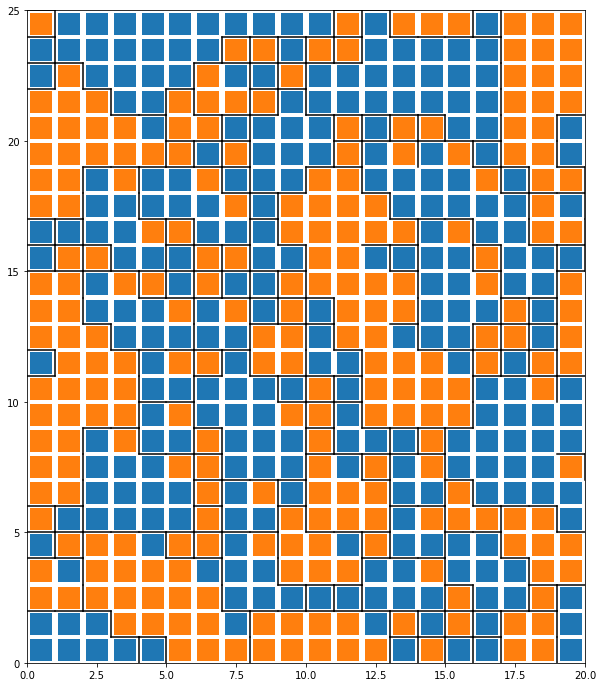

In [120]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(weightskM)
labels_kM = kmeans.labels_
print(labels_kM)
plot_with_labelling(chainlink_som_small,d1,d2,labels_kM,labels_kM,rweights,debug=False)